# 12 - Tabula Muris Baseline VAE and Privacy Audit

This notebook trains and evaluates the baseline VAE on Tabula Muris for cross-dataset validation.

**Goal:** Establish baseline memorization level to compare with PBMC-33k.

Steps:
1. Load preprocessed Tabula Muris data
2. Create train/unseen splits (85/15)
3. Create structured forget set (Cluster 33 - 97 cardiac muscle cells)
4. Create scattered forget set (random 30 cells)
5. Generate matched negatives via k-NN
6. Train baseline VAE (same architecture as PBMC)
7. Train MIA attacker and evaluate baseline AUC
8. Train retrain model and establish target band

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score

from utils import set_global_seed, GLOBAL_SEED, DEVICE, Timer
from vae import VAE, vae_loss
from train import train_epoch, get_kl_weight, create_dataloader
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from train_attacker_conditioned import extract_features_for_split, train_attacker_epoch
from retrain import train_epoch as retrain_train_epoch, create_dataloader_exclude
from attacker_eval import matched_negative_evaluation, compute_attack_metrics

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs/tabula_muris')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'baseline').mkdir(exist_ok=True)
(OUTPUT_DIR / 'retrain').mkdir(exist_ok=True)

print(f"Global seed: {GLOBAL_SEED}")
print(f"Device: {DEVICE}")

2026-01-24 19:41:13.334745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Global seed: 42
Device: cpu


## 1. Load Data

In [2]:
adata = sc.read_h5ad(DATA_DIR / 'tabula_muris_processed.h5ad')
print(f"Loaded Tabula Muris: {adata.shape}")
print(f"Clusters: {adata.obs['leiden'].nunique()}")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_values().head(10))

Loaded Tabula Muris: (41647, 2000)
Clusters: 35

Cluster sizes:
leiden
34     21
33     97
32    261
31    353
30    365
29    394
28    394
27    437
26    457
25    484
Name: count, dtype: int64


## 2. Create Splits

- **Train/Unseen:** 85/15 split
- **Structured forget set:** Cluster 33 (97 cardiac muscle cells)
- **Scattered forget set:** Random 30 cells from training set

In [3]:
# 85/15 train/unseen split
n_cells = adata.n_obs
n_train = int(0.85 * n_cells)

np.random.seed(GLOBAL_SEED)
indices = np.arange(n_cells)
np.random.shuffle(indices)

train_indices = indices[:n_train]
unseen_indices = indices[n_train:]

print(f"Train: {len(train_indices)}, Unseen: {len(unseen_indices)}")

Train: 35399, Unseen: 6248


In [4]:
# Structured forget set: Cluster 33 (cardiac muscle cells)
FORGET_CLUSTER = '33'

cluster_mask = adata.obs['leiden'] == FORGET_CLUSTER
cluster_indices = np.where(cluster_mask)[0]
forget_structured = np.intersect1d(cluster_indices, train_indices)
retain_structured = np.setdiff1d(train_indices, forget_structured)

print(f"Structured split (Cluster {FORGET_CLUSTER}):")
print(f"  Forget: {len(forget_structured)} cells")
print(f"  Retain: {len(retain_structured)} cells")
print(f"  Unseen: {len(unseen_indices)} cells")

# Check cell type composition
forget_cells = adata.obs.iloc[forget_structured]
if 'cell_ontology_class' in forget_cells.columns:
    print(f"\nCell types in forget set:")
    print(forget_cells['cell_ontology_class'].value_counts().head())

Structured split (Cluster 33):
  Forget: 82 cells
  Retain: 35317 cells
  Unseen: 6248 cells

Cell types in forget set:
cell_ontology_class
cardiac muscle cell                  51
                                     31
macrophage                            0
keratinocyte                          0
kidney capillary endothelial cell     0
Name: count, dtype: int64


In [5]:
# Save structured split
split_structured = {
    'forget_indices': [int(i) for i in forget_structured],
    'retain_indices': [int(i) for i in retain_structured],
    'unseen_indices': [int(i) for i in unseen_indices],
    'n_forget': int(len(forget_structured)),
    'n_retain': int(len(retain_structured)),
    'n_unseen': int(len(unseen_indices)),
    'forget_cluster': FORGET_CLUSTER,
    'description': f'Structured forget set: Cluster {FORGET_CLUSTER} (cardiac muscle cells)'
}

with open(OUTPUT_DIR / 'split_structured.json', 'w') as f:
    json.dump(split_structured, f, indent=2)
print(f"Saved {OUTPUT_DIR / 'split_structured.json'}")

Saved ../outputs/tabula_muris/split_structured.json


In [6]:
# Scattered forget set: random 30 cells (to match PBMC)
SCATTER_SIZE = 30

np.random.seed(GLOBAL_SEED + 1)  # Different seed for scattered
forget_scattered = np.random.choice(train_indices, size=SCATTER_SIZE, replace=False)
retain_scattered = np.setdiff1d(train_indices, forget_scattered)

print(f"\nScattered split (random {SCATTER_SIZE}):")
print(f"  Forget: {len(forget_scattered)} cells")
print(f"  Retain: {len(retain_scattered)} cells")

split_scattered = {
    'forget_indices': [int(i) for i in forget_scattered],
    'retain_indices': [int(i) for i in retain_scattered],
    'unseen_indices': [int(i) for i in unseen_indices],
    'n_forget': int(len(forget_scattered)),
    'n_retain': int(len(retain_scattered)),
    'n_unseen': int(len(unseen_indices)),
    'description': f'Scattered forget set: random {SCATTER_SIZE} cells'
}

with open(OUTPUT_DIR / 'split_scattered.json', 'w') as f:
    json.dump(split_scattered, f, indent=2)
print(f"Saved {OUTPUT_DIR / 'split_scattered.json'}")


Scattered split (random 30):
  Forget: 30 cells
  Retain: 35369 cells
Saved ../outputs/tabula_muris/split_scattered.json


## 3. Train Baseline VAE

Same architecture as PBMC:
- Encoder: input -> [1024, 512, 128] -> z=32
- Decoder: z=32 -> [128, 512, 1024] -> input
- Likelihood: Negative Binomial

In [7]:
# Use structured split for baseline training
split = split_structured
train_all = split['forget_indices'] + split['retain_indices']

BATCH_SIZE = 256
train_loader = create_dataloader(adata, train_all, batch_size=BATCH_SIZE, shuffle=True)

print(f"Training on {len(train_all)} cells")
print(f"Batches: {len(train_loader)}")

Training on 35399 cells
Batches: 139


In [8]:
set_global_seed(GLOBAL_SEED)

config = {
    'input_dim': adata.n_vars,
    'hidden_dims': [1024, 512, 128],
    'latent_dim': 32,
    'likelihood': 'nb',
    'dropout': 0.1,
    'use_layer_norm': True,
    'lr': 1e-4,
    'epochs': 100,
    'batch_size': BATCH_SIZE,
    'kl_warmup_epochs': 20,
    'free_bits': 0.03,
    'early_stopping_patience': 10,
    'seed': GLOBAL_SEED,
    'dataset': 'tabula_muris'
}

model = VAE(
    input_dim=config['input_dim'],
    hidden_dims=config['hidden_dims'],
    latent_dim=config['latent_dim'],
    likelihood=config['likelihood'],
    dropout=config['dropout'],
    use_layer_norm=config['use_layer_norm']
).to(DEVICE)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(f"Architecture: {config['input_dim']} -> {config['hidden_dims']} -> z={config['latent_dim']}")

Model parameters: 7,349,984
Architecture: 2000 -> [1024, 512, 128] -> z=32


In [9]:
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

history = {'train_loss': [], 'train_recon': [], 'train_kl': [], 'kl_weight': []}

best_train_loss = float('inf')
patience_counter = 0
print_every = 10
n_genes = config['input_dim']

print(f"Training for up to {config['epochs']} epochs")
print(f"Early stopping patience: {config['early_stopping_patience']}")
print(f"KL warmup: {config['kl_warmup_epochs']} epochs\n")

with Timer("Baseline VAE Training"):
    for epoch in range(config['epochs']):
        kl_weight = get_kl_weight(epoch, config['kl_warmup_epochs'])
        
        train_metrics = train_epoch(
            model, train_loader, optimizer, DEVICE,
            likelihood=config['likelihood'],
            beta=kl_weight,
            free_bits=config['free_bits']
        )
        
        history['train_loss'].append(train_metrics['loss'])
        history['train_recon'].append(train_metrics['recon'])
        history['train_kl'].append(train_metrics['kl'])
        history['kl_weight'].append(kl_weight)
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d}/{config['epochs']} | "
                  f"Loss: {train_metrics['loss']:.1f} ({train_metrics['loss']/n_genes:.3f}/gene) | "
                  f"KL: {kl_weight:.2f}")
        
        if train_metrics['loss'] < best_train_loss:
            best_train_loss = train_metrics['loss']
            patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_metrics['loss'],
                'config': config
            }
            torch.save(checkpoint, OUTPUT_DIR / 'baseline' / 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= config['early_stopping_patience']:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

print(f"\nBest train loss: {best_train_loss:.2f} ({best_train_loss/n_genes:.3f}/gene)")

# Save history
with open(OUTPUT_DIR / 'baseline' / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

Training for up to 100 epochs
Early stopping patience: 10
KL warmup: 20 epochs

[Baseline VAE Training] Starting at 19:41:21


Epoch  10/100 | Loss: 1039.8 (0.520/gene) | KL: 0.45


Epoch  20/100 | Loss: 1023.2 (0.512/gene) | KL: 0.95


Epoch  30/100 | Loss: 1010.5 (0.505/gene) | KL: 1.00


Epoch  40/100 | Loss: 1000.7 (0.500/gene) | KL: 1.00


Epoch  50/100 | Loss: 994.4 (0.497/gene) | KL: 1.00


Epoch  60/100 | Loss: 988.2 (0.494/gene) | KL: 1.00


Epoch  70/100 | Loss: 983.9 (0.492/gene) | KL: 1.00


Epoch  80/100 | Loss: 979.2 (0.490/gene) | KL: 1.00


Epoch  90/100 | Loss: 976.3 (0.488/gene) | KL: 1.00


Epoch 100/100 | Loss: 973.3 (0.487/gene) | KL: 1.00
[Baseline VAE Training] Completed in 66383.68 seconds

Best train loss: 973.01 (0.487/gene)


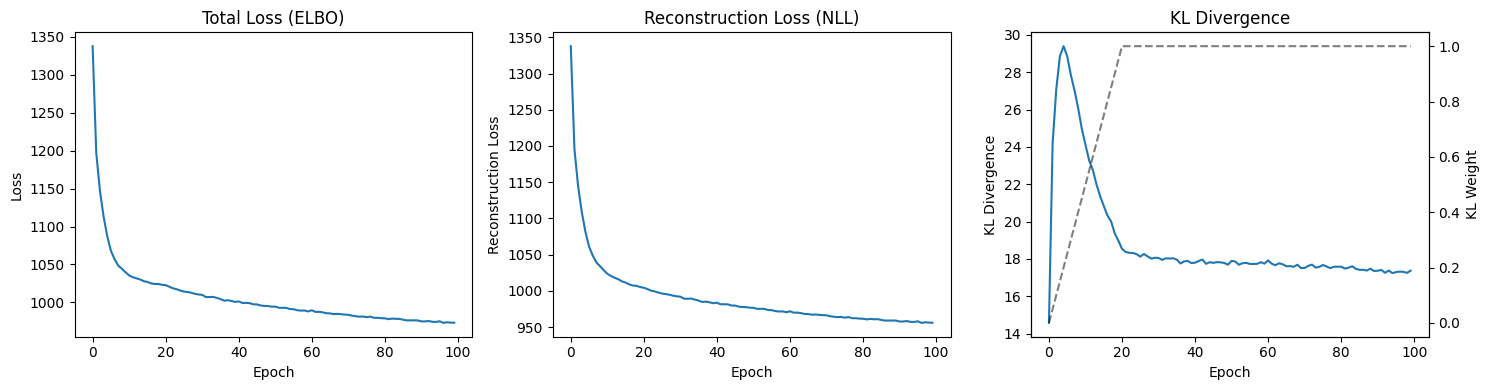

In [10]:
# Training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss (ELBO)')

axes[1].plot(history['train_recon'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss (NLL)')

axes[2].plot(history['train_kl'], label='KL')
ax2 = axes[2].twinx()
ax2.plot(history['kl_weight'], 'k--', alpha=0.5, label='KL weight')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
ax2.set_ylabel('KL Weight')
axes[2].set_title('KL Divergence')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'baseline' / 'training_curves.png', dpi=150)
plt.show()

## 4. Create Matched Negatives

Find unseen cells similar to forget set in VAE latent space (k-NN matching).

In [11]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'baseline' / 'best_model.pt', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.train(False)  # Set to inference mode

def get_latent_codes(model, adata, indices, device):
    """Extract latent codes for given indices."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(device)
    
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
    return z.cpu().numpy()

# Get latent codes
forget_indices = np.array(split['forget_indices'])
unseen_indices_arr = np.array(split['unseen_indices'])

forget_z = get_latent_codes(model, adata, forget_indices, DEVICE)
unseen_z = get_latent_codes(model, adata, unseen_indices_arr, DEVICE)

print(f"Forget latent: {forget_z.shape}")
print(f"Unseen latent: {unseen_z.shape}")

Forget latent: (82, 32)
Unseen latent: (6248, 32)


In [12]:
# k-NN matching
K = 10
nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(unseen_z)
distances, indices_knn = nbrs.kneighbors(forget_z)

# Get unique matched indices (global)
matched_local = np.unique(indices_knn.flatten())
matched_indices = [int(unseen_indices_arr[i]) for i in matched_local]

mean_dist = distances.mean()
median_dist = np.median(distances)

print(f"Matched negatives: {len(matched_indices)} cells")
print(f"Mean k-NN distance: {mean_dist:.4f}")
print(f"Median k-NN distance: {median_dist:.4f}")

# Save matched negatives
matched_data = {
    'matched_indices': matched_indices,
    'method': 'latent_knn',
    'k': K,
    'mean_distance': float(mean_dist),
    'median_distance': float(median_dist)
}
with open(OUTPUT_DIR / 'matched_negatives.json', 'w') as f:
    json.dump(matched_data, f, indent=2)
print(f"Saved {OUTPUT_DIR / 'matched_negatives.json'}")

Matched negatives: 137 cells
Mean k-NN distance: 3.7216
Median k-NN distance: 3.9046
Saved ../outputs/tabula_muris/matched_negatives.json


## 5. Train MIA Attacker

In [13]:
# Extract features
retain_indices_arr = np.array(split['retain_indices'])
retain_z = get_latent_codes(model, adata, retain_indices_arr[:5000], DEVICE)

print("Extracting features for forget set...")
forget_feats, forget_knn_r, _ = extract_features_for_split(
    model, adata, forget_indices, BATCH_SIZE, DEVICE,
    reference_z_retain=retain_z
)

print("Extracting features for matched negatives...")
matched_feats, matched_knn_r, _ = extract_features_for_split(
    model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
    reference_z_retain=retain_z
)

# Build attack features
forget_X = build_attack_features(forget_feats, forget_knn_r, None)
matched_X = build_attack_features(matched_feats, matched_knn_r, None)

feature_dim = forget_X.shape[1]
print(f"\nFeature dimension: {feature_dim}")
print(f"Forget features: {forget_X.shape}")
print(f"Matched features: {matched_X.shape}")

Extracting features for forget set...
Extracting features for matched negatives...



Feature dimension: 70
Forget features: torch.Size([82, 70])
Matched features: torch.Size([137, 70])


In [14]:
# Create training data
member_labels = torch.ones(len(forget_X))
nonmember_labels = torch.zeros(len(matched_X))

all_X = torch.cat([forget_X, matched_X], dim=0)
all_labels = torch.cat([member_labels, nonmember_labels], dim=0)

# Shuffle and split
perm = torch.randperm(len(all_X))
n_train = int(0.8 * len(all_X))

train_X = all_X[perm[:n_train]]
train_y = all_labels[perm[:n_train]]
test_X = all_X[perm[n_train:]]
test_y = all_labels[perm[n_train:]]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader_atk = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_atk = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Attacker train: {len(train_X)}, test: {len(test_X)}")

Attacker train: 175, test: 44


In [15]:
# Train attacker
set_global_seed(GLOBAL_SEED)

attacker = MLPAttacker(
    input_dim=feature_dim,
    hidden_dims=[256, 256],
    dropout=0.3,
    use_spectral_norm=True
).to(DEVICE)

optimizer_atk = optim.Adam(attacker.parameters(), lr=1e-3)

ATTACKER_EPOCHS = 50
print(f"Training attacker for {ATTACKER_EPOCHS} epochs...")

with Timer("Attacker training"):
    for epoch in range(ATTACKER_EPOCHS):
        train_loss = train_attacker_epoch(attacker, train_loader_atk, optimizer_atk, DEVICE)
        
        if (epoch + 1) % 10 == 0:
            # Quick test evaluation
            attacker.train(False)
            with torch.no_grad():
                test_preds = torch.sigmoid(attacker(test_X.to(DEVICE))).cpu().numpy().flatten()
            test_auc = roc_auc_score(test_y.numpy(), test_preds)
            attacker.train(True)
            print(f"Epoch {epoch+1}/{ATTACKER_EPOCHS} - Loss: {train_loss:.4f} - Test AUC: {test_auc:.4f}")

Training attacker for 50 epochs...
[Attacker training] Starting at 14:07:47


Epoch 10/50 - Loss: 1.5636 - Test AUC: 0.8738


Epoch 20/50 - Loss: 1.1075 - Test AUC: 0.8786


Epoch 30/50 - Loss: 0.9636 - Test AUC: 0.8905

Epoch 40/50 - Loss: 0.8142 - Test AUC: 0.9286


Epoch 50/50 - Loss: 0.7400 - Test AUC: 0.8905
[Attacker training] Completed in 0.30 seconds


In [16]:
# Evaluate baseline
baseline_metrics = matched_negative_evaluation(
    attacker, forget_X, matched_X, device=DEVICE
)

print("=== Baseline MIA Results (Tabula Muris) ===")
print(f"AUC: {baseline_metrics['auc']:.4f}")
print(f"95% CI: [{baseline_metrics['auc_ci_lower']:.4f}, {baseline_metrics['auc_ci_upper']:.4f}]")
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"TPR@1%FPR: {baseline_metrics['tpr_at_fpr_01']:.4f}")
print(f"TPR@5%FPR: {baseline_metrics['tpr_at_fpr_05']:.4f}")

# Save attacker
attacker_ckpt = {
    'model_state_dict': attacker.state_dict(),
    'config': {'input_dim': feature_dim, 'hidden_dims': [256, 256], 'dropout': 0.3},
    'baseline_auc': baseline_metrics['auc'],
    'metrics': baseline_metrics
}
torch.save(attacker_ckpt, OUTPUT_DIR / 'attacker.pt')
print(f"\nSaved attacker to {OUTPUT_DIR / 'attacker.pt'}")

=== Baseline MIA Results (Tabula Muris) ===
AUC: 0.8909
95% CI: [0.8477, 0.9305]
Accuracy: 0.4977
TPR@1%FPR: 0.1220
TPR@5%FPR: 0.3902

Saved attacker to ../outputs/tabula_muris/attacker.pt


## 6. Train Retrain Model and Establish Target Band

In [17]:
# Split retain into train/val for retraining
np.random.seed(GLOBAL_SEED)
retain_shuffled = retain_indices_arr.copy()
np.random.shuffle(retain_shuffled)
n_train_retrain = int(0.85 * len(retain_shuffled))

train_indices_retrain = retain_shuffled[:n_train_retrain]
val_indices_retrain = retain_shuffled[n_train_retrain:]

train_loader_retrain = create_dataloader_exclude(
    adata, train_indices_retrain, [], batch_size=BATCH_SIZE, shuffle=True
)

print(f"Retrain data (D\\F):")
print(f"  Train: {len(train_indices_retrain)}")
print(f"  Val: {len(val_indices_retrain)}")

Retrain data (D\F):
  Train: 30019
  Val: 5298


In [18]:
# Initialize retrain model
set_global_seed(GLOBAL_SEED)

retrain_model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    likelihood=config['likelihood'],
    dropout=config.get('dropout', 0.1),
    use_layer_norm=config.get('use_layer_norm', True)
).to(DEVICE)

optimizer_retrain = optim.Adam(retrain_model.parameters(), lr=config.get('lr', 1e-4))

print(f"Initialized retrain VAE: {sum(p.numel() for p in retrain_model.parameters()):,} parameters")

Initialized retrain VAE: 7,349,984 parameters


In [19]:
# Train retrain model
RETRAIN_EPOCHS = 100
best_train_loss_retrain = float('inf')

print(f"Training retrain model for {RETRAIN_EPOCHS} epochs...")

with Timer("Retrain"):
    for epoch in range(RETRAIN_EPOCHS):
        train_metrics = retrain_train_epoch(
            retrain_model, train_loader_retrain, optimizer_retrain,
            DEVICE, config['likelihood'], beta=1.0
        )
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{RETRAIN_EPOCHS} - Train Loss: {train_metrics['loss']:.4f}")
        
        if train_metrics['loss'] < best_train_loss_retrain:
            best_train_loss_retrain = train_metrics['loss']
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': retrain_model.state_dict(),
                'train_loss': train_metrics['loss'],
                'config': config
            }
            torch.save(checkpoint, OUTPUT_DIR / 'retrain' / 'best_model.pt')

print(f"\nBest retrain loss: {best_train_loss_retrain:.4f}")

Training retrain model for 100 epochs...
[Retrain] Starting at 14:07:50


Epoch 10/100 - Train Loss: 1060.7891


Epoch 20/100 - Train Loss: 1026.1473


Epoch 30/100 - Train Loss: 1011.6461


Epoch 40/100 - Train Loss: 1001.4783


Epoch 50/100 - Train Loss: 993.8708


Epoch 60/100 - Train Loss: 988.8076


Epoch 70/100 - Train Loss: 985.1069


Epoch 80/100 - Train Loss: 979.5688


Epoch 90/100 - Train Loss: 974.3706


Epoch 100/100 - Train Loss: 971.4153
[Retrain] Completed in 10991.49 seconds

Best retrain loss: 971.1285


In [20]:
# Load best retrain model and evaluate
retrain_ckpt = torch.load(OUTPUT_DIR / 'retrain' / 'best_model.pt', map_location=DEVICE)
retrain_model.load_state_dict(retrain_ckpt['model_state_dict'])
retrain_model.train(False)  # Set to inference mode

# Get features from retrain model
retrain_retain_z = get_latent_codes(retrain_model, adata, retain_indices_arr[:5000], DEVICE)

print("Extracting features from retrain model...")
retrain_forget_feats, retrain_forget_knn, _ = extract_features_for_split(
    retrain_model, adata, forget_indices, BATCH_SIZE, DEVICE,
    reference_z_retain=retrain_retain_z
)
retrain_forget_X = build_attack_features(retrain_forget_feats, retrain_forget_knn, None)

retrain_matched_feats, retrain_matched_knn, _ = extract_features_for_split(
    retrain_model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
    reference_z_retain=retrain_retain_z
)
retrain_matched_X = build_attack_features(retrain_matched_feats, retrain_matched_knn, None)

Extracting features from retrain model...


In [21]:
# Evaluate retrain floor
retrain_metrics = matched_negative_evaluation(
    attacker, retrain_forget_X, retrain_matched_X, device=DEVICE
)

print("=== Retrain Floor (Tabula Muris) ===")
print(f"AUC: {retrain_metrics['auc']:.4f}")
print(f"95% CI: [{retrain_metrics['auc_ci_lower']:.4f}, {retrain_metrics['auc_ci_upper']:.4f}]")

# Define target band
retrain_floor = retrain_metrics['auc']
target_band = [retrain_floor - 0.03, retrain_floor + 0.03]

print(f"\nTarget band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")

=== Retrain Floor (Tabula Muris) ===
AUC: 0.9443
95% CI: [0.9092, 0.9744]

Target band: [0.9143, 0.9743]


In [22]:
# Save results
results = {
    'dataset': 'tabula_muris',
    'baseline_auc': float(baseline_metrics['auc']),
    'baseline_ci': [float(baseline_metrics['auc_ci_lower']), float(baseline_metrics['auc_ci_upper'])],
    'retrain_floor': float(retrain_floor),
    'retrain_ci': [float(retrain_metrics['auc_ci_lower']), float(retrain_metrics['auc_ci_upper'])],
    'target_band': [float(x) for x in target_band],
    'forget_set': {
        'type': 'structured',
        'cluster': FORGET_CLUSTER,
        'size': len(forget_indices),
        'cell_type': 'cardiac muscle cell'
    },
    'matched_negatives': len(matched_indices)
}

with open(OUTPUT_DIR / 'baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved results to {OUTPUT_DIR / 'baseline_results.json'}")


Saved results to ../outputs/tabula_muris/baseline_results.json


## 7. Summary and Comparison

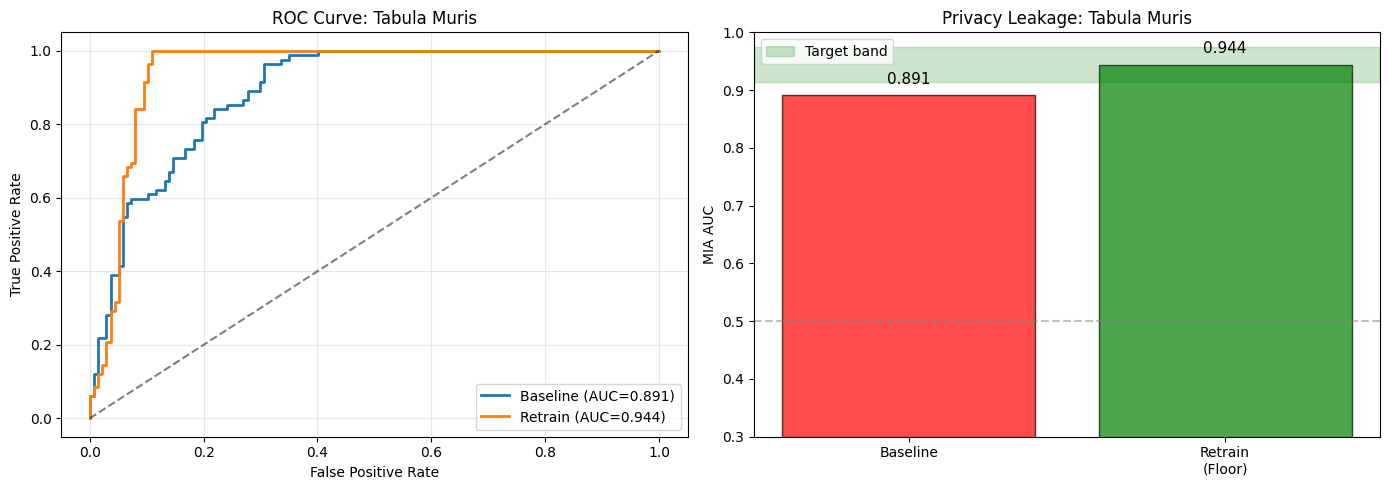

In [23]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
attacker.train(False)
with torch.no_grad():
    baseline_probs = torch.sigmoid(attacker(forget_X.to(DEVICE))).cpu().numpy().flatten()
    baseline_neg_probs = torch.sigmoid(attacker(matched_X.to(DEVICE))).cpu().numpy().flatten()
    retrain_probs = torch.sigmoid(attacker(retrain_forget_X.to(DEVICE))).cpu().numpy().flatten()
    retrain_neg_probs = torch.sigmoid(attacker(retrain_matched_X.to(DEVICE))).cpu().numpy().flatten()

baseline_y = np.concatenate([np.ones(len(baseline_probs)), np.zeros(len(baseline_neg_probs))])
baseline_scores = np.concatenate([baseline_probs, baseline_neg_probs])
baseline_fpr, baseline_tpr, _ = roc_curve(baseline_y, baseline_scores)

retrain_y = np.concatenate([np.ones(len(retrain_probs)), np.zeros(len(retrain_neg_probs))])
retrain_scores = np.concatenate([retrain_probs, retrain_neg_probs])
retrain_fpr, retrain_tpr, _ = roc_curve(retrain_y, retrain_scores)

axes[0].plot(baseline_fpr, baseline_tpr, label=f"Baseline (AUC={baseline_metrics['auc']:.3f})", linewidth=2)
axes[0].plot(retrain_fpr, retrain_tpr, label=f"Retrain (AUC={retrain_metrics['auc']:.3f})", linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve: Tabula Muris')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Comparison bar chart
methods = ['Baseline', 'Retrain\n(Floor)']
aucs = [baseline_metrics['auc'], retrain_metrics['auc']]
colors = ['red', 'green']
bars = axes[1].bar(methods, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('MIA AUC')
axes[1].set_title('Privacy Leakage: Tabula Muris')
axes[1].set_ylim([0.3, 1.0])
axes[1].legend()

for bar, auc in zip(bars, aucs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{auc:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'baseline_vs_retrain.png', dpi=150)
plt.show()

In [24]:
print("="*60)
print("TABULA MURIS BASELINE SUMMARY")
print("="*60)
print(f"\nDataset: {adata.shape[0]} cells, {adata.shape[1]} genes")
print(f"Forget set: Cluster {FORGET_CLUSTER} ({len(forget_indices)} cardiac muscle cells)")
print(f"Matched negatives: {len(matched_indices)} cells")
print(f"\nBaseline AUC: {baseline_metrics['auc']:.4f} (CI: [{baseline_metrics['auc_ci_lower']:.4f}, {baseline_metrics['auc_ci_upper']:.4f}])")
print(f"Retrain floor: {retrain_floor:.4f} (CI: [{retrain_metrics['auc_ci_lower']:.4f}, {retrain_metrics['auc_ci_upper']:.4f}])")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")
print(f"\n" + "="*60)
print("COMPARISON WITH PBMC-33k")
print("="*60)
print(f"\n{'Metric':<25} {'PBMC-33k':<15} {'Tabula Muris':<15}")
print("-"*55)
print(f"{'Cells':<25} {'33,088':<15} {adata.shape[0]:<15}")
print(f"{'Forget set size':<25} {'30':<15} {len(forget_indices):<15}")
print(f"{'Baseline AUC':<25} {'0.769':<15} {baseline_metrics['auc']:.3f}")
print(f"{'Retrain floor':<25} {'0.481':<15} {retrain_floor:.3f}")

TABULA MURIS BASELINE SUMMARY

Dataset: 41647 cells, 2000 genes
Forget set: Cluster 33 (82 cardiac muscle cells)
Matched negatives: 137 cells

Baseline AUC: 0.8909 (CI: [0.8477, 0.9305])
Retrain floor: 0.9443 (CI: [0.9092, 0.9744])
Target band: [0.9143, 0.9743]

COMPARISON WITH PBMC-33k

Metric                    PBMC-33k        Tabula Muris   
-------------------------------------------------------
Cells                     33,088          41647          
Forget set size           30              82             
Baseline AUC              0.769           0.891
Retrain floor             0.481           0.944


## Summary

### Outputs Created
| Output | Path |
|--------|------|
| Structured split | `outputs/tabula_muris/split_structured.json` |
| Scattered split | `outputs/tabula_muris/split_scattered.json` |
| Baseline model | `outputs/tabula_muris/baseline/best_model.pt` |
| Retrain model | `outputs/tabula_muris/retrain/best_model.pt` |
| Attacker | `outputs/tabula_muris/attacker.pt` |
| Results | `outputs/tabula_muris/baseline_results.json` |

### Next Steps
- `13_tabula_muris_unlearning.ipynb`: Run extra-gradient and Fisher unlearning
- Compare results with PBMC-33k findings